In [33]:
! pip install simplification

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 709.2/709.2 kB 12.3 MB/s eta 0:00:00a 0:00:01


In [47]:
import json
import ndjson
import numpy as np
import matplotlib.pyplot as plt
import math
from simplification.cutil import simplify_coords

In [16]:
with open('/home/raj/code/rs-uk/pictionary-ai/shared_data/drawing_input_test2.json','r') as f :
        drawing_input = json.load(f)

In [17]:
drawing_input = eval(drawing_input)

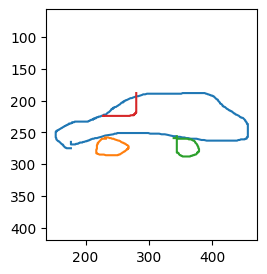

In [44]:
drawing = drawing_input

plt.figure(figsize=(6,3))

for stroke in drawing['drawing'] :
    x = stroke[0]
    y = stroke[1]

    plt.subplot(1,2,2)
    plt.plot(x, y, marker='')
    #plt.axis('off')

plt.gca().invert_yaxis()
plt.axis('equal')
plt.show()

In [37]:
def resample(x, y, spacing=1.0):
    output = []
    n = len(x)
    px = x[0]
    py = y[0]
    cumlen = 0
    pcumlen = 0
    offset = 0
    for i in range(1, n):
        cx = x[i]
        cy = y[i]
        dx = cx - px
        dy = cy - py
        curlen = math.sqrt(dx*dx + dy*dy)
        cumlen += curlen
        while offset < cumlen:
            t = (offset - pcumlen) / curlen
            invt = 1 - t
            tx = px * invt + cx * t
            ty = py * invt + cy * t
            output.append((tx, ty))
            offset += spacing
        pcumlen = cumlen
        px = cx
        py = cy
    output.append((x[-1], y[-1]))
    return output
  
def normalize_resample_simplify(strokes, epsilon=1.0, resample_spacing=1.0):
    if len(strokes) == 0:
        raise ValueError('empty image')

    # find min and max
    amin = None
    amax = None
    for x, y in strokes:
        cur_min = [np.min(x), np.min(y)]
        cur_max = [np.max(x), np.max(y)]
        amin = cur_min if amin is None else np.min([amin, cur_min], axis=0)
        amax = cur_max if amax is None else np.max([amax, cur_max], axis=0)

    # drop any drawings that are linear along one axis
    arange = np.array(amax) - np.array(amin)
    if np.min(arange) == 0:
        raise ValueError('bad range of values')

    arange = np.max(arange)
    output = []
    for x, y in strokes:
        xy = np.array([x, y], dtype=float).T
        xy -= amin
        xy *= 255.
        xy /= arange
        resampled = resample(xy[:, 0], xy[:, 1], resample_spacing)
        simplified = simplify_coords(resampled, epsilon)
        xy = np.around(simplified).astype(np.uint8)
        output.append(xy.T.tolist())

    return output

In [38]:
output = normalize_resample_simplify(drawing_input['drawing'])

In [40]:
print(output)

[[[20, 13, 1, 0, 1, 22, 43, 55, 67, 74, 94, 121, 198, 209, 222, 248, 255, 255, 253, 240, 200, 137, 83, 49, 26, 21, 20], [73, 72, 62, 59, 50, 39, 38, 32, 29, 21, 9, 1, 0, 4, 18, 33, 42, 58, 60, 63, 63, 54, 53, 61, 68, 68, 65]], [[66, 61, 56, 54, 67, 82, 97, 95, 84, 66], [61, 61, 67, 80, 82, 82, 73, 69, 63, 59]], [[161, 161, 165, 168, 178, 186, 190, 189, 184, 174, 157], [57, 79, 82, 84, 84, 81, 77, 72, 63, 61, 60]], [[63, 103, 107, 107], [30, 29, 25, 0]]]


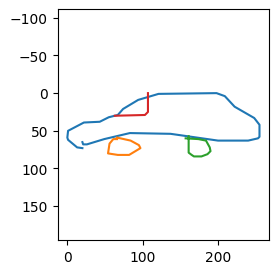

In [43]:
drawing = output

plt.figure(figsize=(6,3))

for stroke in drawing :
    x = stroke[0]
    y = stroke[1]

    plt.subplot(1,2,2)
    plt.plot(x, y, marker='')
    #plt.axis('off')

plt.gca().invert_yaxis()
plt.axis('equal')
plt.show()

In [45]:
from google.cloud import storage

# Download a blob from a bucket and store it in memory
def download_blob_to_memory(bucket_name, source_blob_name) -> list:
    '''
    Downloads a (ndjson) blob from the bucket and return json file as dict
    '''
    # Initialize a client
    storage_client = storage.Client()

    # Get the bucket
    bucket = storage_client.bucket(bucket_name)

    # Get the blob
    blob = bucket.blob(source_blob_name)

    # Download the blob content as a string
    blob_content = blob.download_as_string()

    # Need to replace all single quotes with double quotes for processed
    # Not need once processing code has been updated
    blob_content = str(blob_content, encoding='utf-8').replace("'",'"')

    # Load JSON from the blob contents
    json_data = ndjson.loads(blob_content)

    # Returns a list of dictionaries - each dictionary represents one drawing
    return json_data

In [48]:
folder_path = 'quickdraw-simplified'
blob = 'car.ndjson'

json_data = download_blob_to_memory(folder_path, blob)

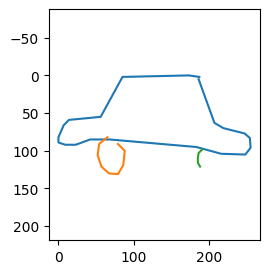

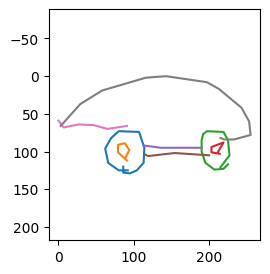

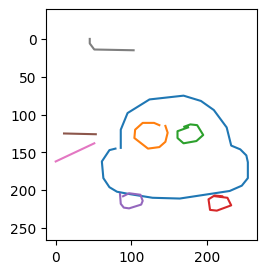

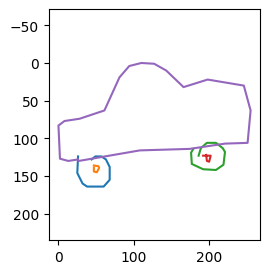

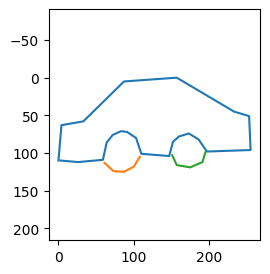

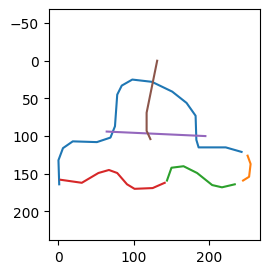

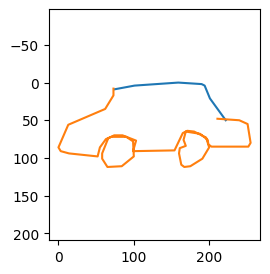

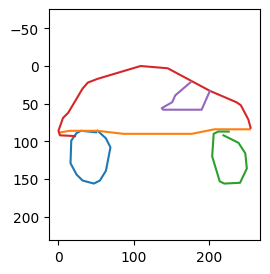

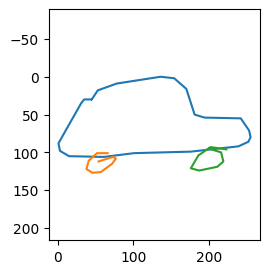

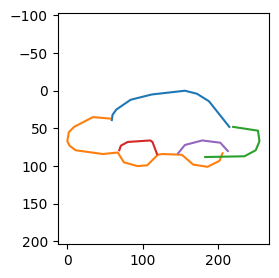

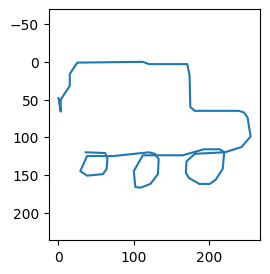

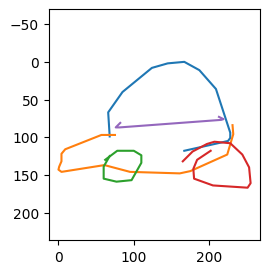

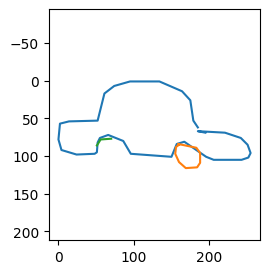

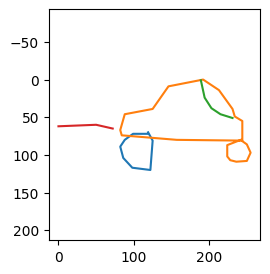

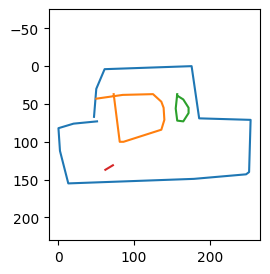

In [50]:
for i in range(15) : 
    drawing = json_data[i]['drawing']

    plt.figure(figsize=(6,3))
    
    for stroke in drawing :
        x = stroke[0]
        y = stroke[1]
    
        plt.subplot(1,2,2)
        plt.plot(x, y, marker='')
        #plt.axis('off')
    
    plt.gca().invert_yaxis()
    plt.axis('equal')
    plt.show()